# Twitter Climate Change Sentiment Analysis

<p align="center">
    <img src="https://hub.packtpub.com/wp-content/uploads/2018/03/Sentiment-Analysis-Tw.png"  />
</p>

## Overview
In this project, we develop an NLP sentiment analysis model using aggregated tweets related to climate change between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:

- 2(News): the tweet links to factual news about climate change
- 1(Pro): the tweet supports the belief of man-made climate change
- 0(Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1(Anti): the tweet does not believe in man-made climate change


##  Table of Contents
- [Installation](#installation)
- [Data Gathering](#data-gathering)
- [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [Feature Extraction](#feature-extraction)
- [Modeling](#modeling)
- [Deployment via Streamlit](#deployment-via-streamlit)
- [GitHub Integration](#github-integration)
- [Communication and Interpretation](#communication-and-interpretation)
- [Contributing](#contributing)

# 0. Load Libraries

In [4]:
pip install unidecode streamlit comet_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.8/675.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
#dataset manipulation
import pandas as pd 
import numpy as np 
#for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
#for stats
import scipy.stats as stats
#for data cleaning and preprocessing 
import re
import nltk 
from unidecode import unidecode
from nltk.corpus import stopwords
import spacy 
from wordcloud import WordCloud
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#for experimental tracking 
import comet_ml
from comet_ml import Experiment 
#for modelling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
#for evaluation
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
#for deployment
import streamlit as st 
#misc functions
from collections import Counter
import pickle
import os
import warnings
warnings.filterwarnings(action = 'ignore')
from scipy.stats import randint, uniform
from git import Repo

#visualisation configs
palette = sns.color_palette()

import matplotlib.style as style
style.use('fivethirtyeight')
sns.set_style('darkgrid')

#file management
os.environ['TRAIN_DATA'] = '/kaggle/input/twitter-sentiment-edsa/train.csv'
os.environ['TEST_DATA'] = '/kaggle/input/twitter-sentiment-edsa/test_with_no_labels.csv'
os.environ['EXPORT_DATA'] = '/kaggle/working/preprocessed_twitter_sentiment_data.csv'

#api
os.environ['API_KEY'] = 'gRDjhvM5j3nQFdkpLREGdZxJ3'

# 1. Data Gathering

- This step involves collecting tweets related to climate change. We will use the dataset publicly available in https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset. The dataset is described in the overview.

In [6]:
#read dataset into a dataframe
df_train = pd.read_csv(os.environ.get('TRAIN_DATA'))
df_test = pd.read_csv(os.environ.get('TEST_DATA'))

In [7]:
#view dataset |training
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [8]:
#view dataset | testing
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [9]:
#data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [10]:
#size of the dataset 
print(f"The training dataset has {len(df_train)} tweeets belonging to {df_train['sentiment'].nunique()} sentiment classes")
print(f"The test dataset has {len(df_test)} tweeets")

The training dataset has 15819 tweeets belonging to 4 sentiment classes
The test dataset has 10546 tweeets


In [11]:
#view sample tweets
def sample_tweets(df, sentiment, sample_size = 5):
    '''
    Returns a sample of tweets corresponding to a sentiment class
    
    Parameters:
        sentiment (int): sentiment class
        sample_size (int): number of corresponding tweets to return
        
    Returns:
        str: tweets corresponding to sentiment
    '''
    
    mask = (df['sentiment'] == sentiment)
    df_masked = df[mask]

    for i in df_masked.index[:sample_size].tolist():
        print(df_masked.loc[i, 'message'])


In [12]:
#view (anti man-man climate)
sample_tweets(df_train, -1)

Sally Kohn’s latest evidence of climate change proves she is ‘not a smart person’ https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more
@realDonaldTrump Carbon Tax is a Globalist idea to enslave the world's population. It is the whole reason for propagating global warming!
RT @SteveSGoddard: We had winds close to 100 MPH in the area this afternoon. I would blame climate change, except that this happens pr… 
@MissLizzyNJ lmao 😂 snowflakes ❄️ complaining about snowflakes ❄️ in winter =global warming 🤦‍♂️
RT @Dawn2334Dawn: This is ONE of Arnold Schwarzenegger's vehicles. He is now whining about climate change.
How's his maid...illegal or
http…


In [13]:
#view (neutral man-man climate)
sample_tweets(df_train, 0)

Calum: *tweets abt reunitingish w the cast*
-sees replies begging him to come to their countries-
Calum: *goes back to rting climate change*
we also met this guy, he let us in on some truth about climate change and gay people not existing https://t.co/Q7yOMcMZaj
@Jnp_Ftw are these the same scientists that denounce climate change? It's not a choice
We’ ve dealt with simple issues like climate change and energy policy. Now the complex issues. Mal vs Tones. #qanda
RT @andrewsharp: Win probability is bullshit man. I saw the NBA Finals and that's when I knew, global warming isn't real


In [14]:
#view (pro man-man climate)
sample_tweets(df_train, 1)

PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable
It's not like we lack evidence of anthropogenic global warming
#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD
RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight
Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j


In [15]:
#view (factual news)
sample_tweets(df_train, 2)

RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
RT @tveitdal: We only have a 5 percent chance of avoiding ‘dangerous’ global warming, a study finds https://t.co/xUBTqNxhkK https://t.co/of…
Fossil fuel giant ExxonMobil ‘misled’ the public about climate change, Harvard academics conclude https://t.co/ofc2WSu4EX
Bangladesh confronting climate change head on https://t.co/MTqeNBQDUt https://t.co/itgkUxgEfg
RT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…


# 2. Data Cleaning and Preprocessing

- In this section we ensures the raw tweet data is clean and ready for analysis. It includes several sub-steps:

  - **Normalization**: Converts all text to lowercase to ensure uniformity.
  - **Removing URLs, Mentions, and Hashtags**: Uses regular expressions (`re` library) to strip out unwanted parts of the text.
  - **Stopwords Removal**: Removes common words that do not contribute much meaning, using `nltk`'s stopwords.
  - **Stemming and Lemmatization**: Reduces words to their base or root form. Stemming uses `nltk`'s `PorterStemmer`, and lemmatization uses `spacy`'s lemmatizer.

## 2.1. Check for duplicates

In [16]:
print(f"The number of duplicated tweets in training dataset are {df_train.duplicated(subset = ['message']).sum()}")
print(f"The number of duplicated tweets in test dataset are {df_test.duplicated(subset = ['message']).sum()}")

The number of duplicated tweets in training dataset are 1590
The number of duplicated tweets in test dataset are 971


In [17]:
#drop duplicates
df_train.drop_duplicates(subset = ['message'], inplace = True)
df_test.drop_duplicates(subset = ['message'], inplace = True)

## 2.2. Check for Missing Tweets

In [18]:
print(f"The number of missing tweets is {df_train['message'].isnull().sum().sum()}")
print(f"The number of missing tweets is {df_test['message'].isnull().sum().sum()}")

The number of missing tweets is 0
The number of missing tweets is 0


## 2.3. Normalization 

In [19]:
#Converts all text to lowercase to ensure uniformity
df_train['message'] = df_train['message'].str.lower()
df_test['message'] = df_test['message'].str.lower()

In [20]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


In [21]:
#save for EDA phase 
df_eda = df_train.copy(deep = True)

  ## 2.4. Regular Expression | Filtering
  
Since tweet data can be noisy and messy, we will utilise pattern search via regular expressions to remove the following:

- URLS
- Mentions
- Retweets
- Hashtags
- Numeric characters
- Accents
- Spaces 

This will improve the quality of the dataset and ensure that is it more suitable for vectorisation
 

In [22]:
# Removing URLs, mentions, retweets and hashtags
# Use regular expressions to strip out unwanted parts of the text.
def tweet_filtering(message):
    '''
    Utility function to preprocess the tweets by removing special characters,
    accents and digits
    
    Args:
        message (pd.Series): raw tweets to be preprocessed
        
    Returns:
        pd.Series: preprocessed tweets
    '''
    
    # remove urls
    message = message.replace(to_replace = r"https?:\/\/.*\/\w*", value = ' ', regex = True)
    #remove mentions
    message = message.replace(to_replace = "@[\w]*", value = ' ', regex = True)
    #remove retweets
    message = message.replace(to_replace = r"^\s*rt\s+", value = ' ', regex = True)
    #remove hashtags
    message = message.replace(to_replace = r"#\w*", value = ' ', regex = True)
    #remove special characters
    message = message.replace(to_replace = r"\W", value = ' ', regex = True)
    #remove digits
    message = message.replace(to_replace = r"\d+", value = ' ', regex = True)
    #remove large whitespaces
    message = message.replace(to_replace = "\s\s+", value = ' ')
    #remove extract spacce
    message = message.str.strip(' ')
    #remove accents
    message = message.apply(unidecode)

    return message

In [23]:
#apply filtering
df_train['message'] = tweet_filtering(df_train['message'])
df_test['message'] = tweet_filtering(df_test['message'])

In [24]:
#view 
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,researchers say we have three years to act on ...,698562
3,1,wired was a pivotal year in the war on cli...,573736
4,1,it s and a racist sexist climate change d...,466954


In [25]:
#sample
sample_tweets(df_train, -1)

sally kohn s latest evidence of climate change proves she is  not a smart person    via   need we say more
carbon tax is a globalist idea to enslave the world s population  it is the whole reason for propagating global warming
we had winds close to   mph in the area this afternoon  i would blame climate change  except that this happens pr
lmao   snowflakes    complaining about snowflakes    in winter  global warming
this is one of arnold schwarzenegger s vehicles  he is now whining about climate change  how s his maid   illegal or http


## 2.5. Stopwords Removal

In [26]:
#define stop words
stop_words = set(stopwords.words('english'))

In [27]:
#remove stop words
def remove_stopwords(message):
    '''
    Remove stop words i.e. words which do not add meaning to text
    
    Args:
        message (pd.Series): raw tweets 
        
    Returns:
        pd.Series: filtered tweeets without stopwords
    '''
    return ' '.join([word for word in message.split() if word not in stop_words])

In [28]:
df_train['message'] = df_train['message'].apply(remove_stopwords)
df_test['message'] = df_test['message'].apply(remove_stopwords)

In [29]:
sample_tweets(df_train, 1,2)

polyscimajor epa chief think carbon dioxide main cause global warming wait via
like lack evidence anthropogenic global warming


In [30]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researchers say three years act climate change...,698562
3,1,wired pivotal year war climate change,573736
4,1,racist sexist climate change denying bigot lea...,466954


## 2.6. Lemmatization

**Note**: We used lemmatization over stemming since lemmatization always returns actual words, as opposed to stemming, which may not, affecting intepretability of results. However, lemmatization is computationally costly.

In [31]:
#reduces words to their base or dictionary form 
nlp = spacy.load("en_core_web_sm")

In [32]:
#lemmatize text
def lemmatize_text(message):
    '''
    This function takes raw text (tweets) and reduces each word to its base/dictionary form
    
    Args:
        message (pd.Series): raw tweets to be processed
        
    Returns:
        pd.Series: lemmatized text
    '''
    doc = nlp(message)
    return ' '.join([token.lemma_ for token in doc])

In [33]:
%%time
df_train['message'] = df_train['message'].apply(lemmatize_text)
df_test['message'] = df_test['message'].apply(lemmatize_text)

CPU times: user 2min 26s, sys: 46.1 ms, total: 2min 26s
Wall time: 2min 26s


In [34]:
#check
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researcher say three year act climate change late,698562
3,1,wire pivotal year war climate change,573736
4,1,racist sexist climate change deny bigot lead poll,466954


In [35]:
#view
sample_tweets(df_train, 2,2)

researcher say three year act climate change late
percent chance avoid dangerous global warming study find


In [37]:
#view 
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researcher say three year act climate change late,698562
3,1,wire pivotal year war climate change,573736
4,1,racist sexist climate change deny bigot lead poll,466954


In [38]:
#save preprocessed file
export_path = os.environ.get('EXPORT_DATA')
df_train.to_csv(export_path, index = False)

# 3. Exploratory Data Analysis (EDA)

EDA involves visualizing and understanding the structure and main characteristics of the data. This step includes:

- Sentiment distribution
- Word frequency distribution

In [39]:
#reimport data
export_path = os.environ.get('EXPORT_DATA')
df_train  = pd.read_csv(export_path)

In [40]:
#view
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researcher say three year act climate change late,698562
3,1,wire pivotal year war climate change,573736
4,1,racist sexist climate change deny bigot lead poll,466954


In [41]:
#remove empty processed tweets
df_train = df_train[~df_train['message'].isna()].reset_index(drop = True)
df_test = df_test[~df_test['message'].isna()].reset_index(drop = True)

## 3.1. Sentiment Distribution

In [42]:
#map labels for eda purposes
sentiment_class_dict = {-1: 'Anti', 0: 'Neutral', 1: 'Pro', 2: 'Factual'}

df_train['sentiment'] = df_train['sentiment'].map(sentiment_class_dict)

In [43]:
#visualise sentiment distribution
def plot_sentiment_distribution(df):
    plt.figure(figsize = (10, 5))
    sns.countplot(x = 'sentiment', data = df)
    plt.xlabel('Sentiment Class')
    plt.ylabel('Total Number of Tweets')
    plt.title('Sentiment Class Distribution')
    plt.show()

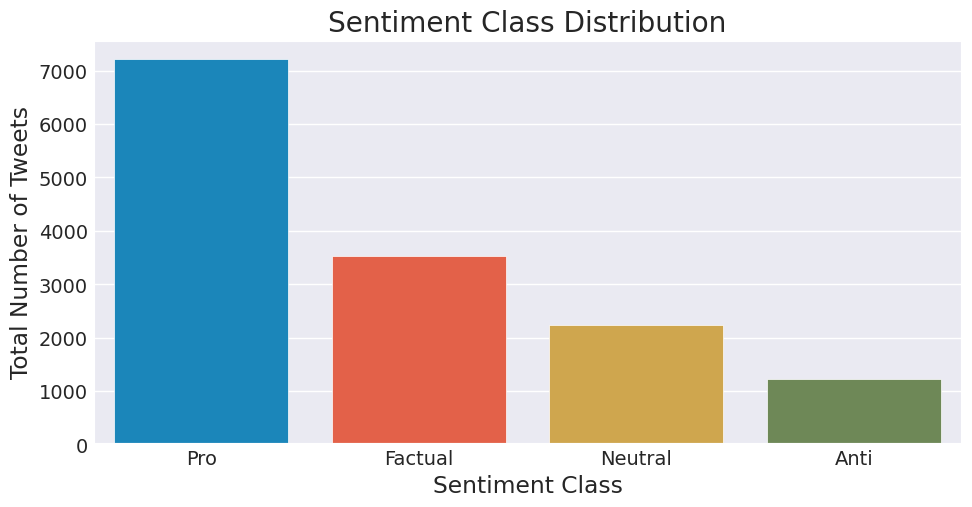

In [44]:
#sentiment distribution
plot_sentiment_distribution(df_train)

**Observation**: In the above graph, it is observed that the classes are imbalanced with most tweets belonging `Pro` class

## 3.2.  Word Cloud 

In [45]:
#creates a visual representation of the most frequent words in the dataset 
def plot_wordcloud(message):
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(message)
    plt.figure(figsize = (10,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [46]:
#concatenate all tweets
all_text = ' '.join(df_train['message'])

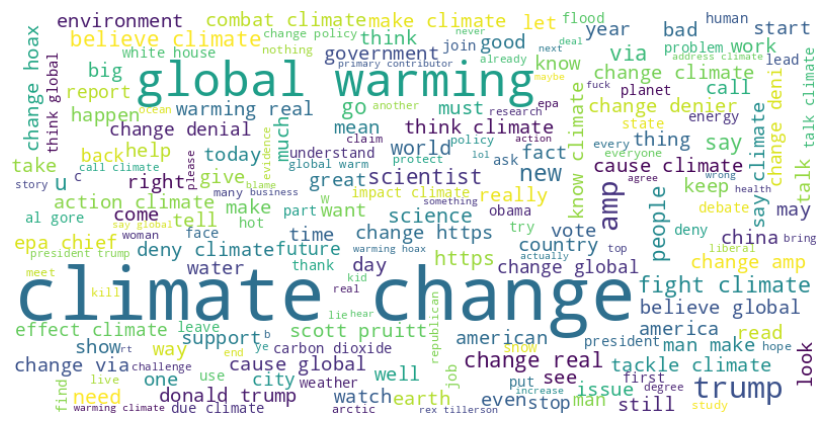

In [47]:
#view common words
plot_wordcloud(all_text)

## 3.3. Word Frequency Distribution


In [48]:
def plot_frequency_distribution(message, sentiment_class = 'All', top_n=20):
    words = message.split()
    freq_dist = Counter(words)
    common_words = freq_dist.most_common(top_n)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x = np.array(counts), y= np.array(words))
    plt.title(f'Top {top_n} Most Common Words for {sentiment_class} Class')
    plt.show()

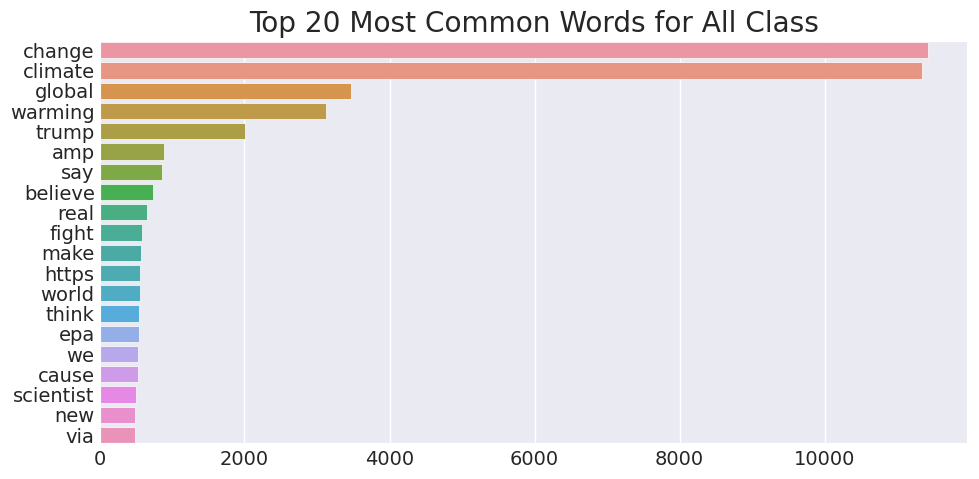

In [49]:
# Plot frequency distribution
plot_frequency_distribution(all_text)

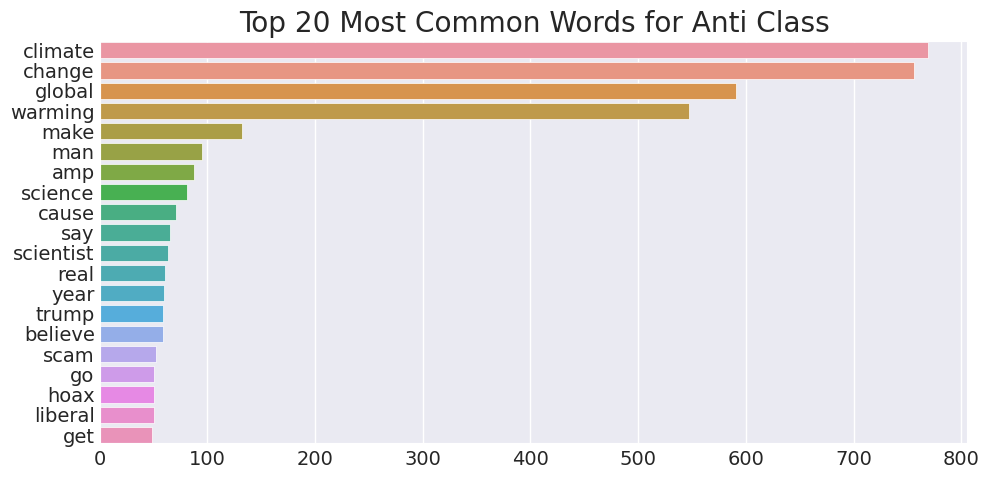

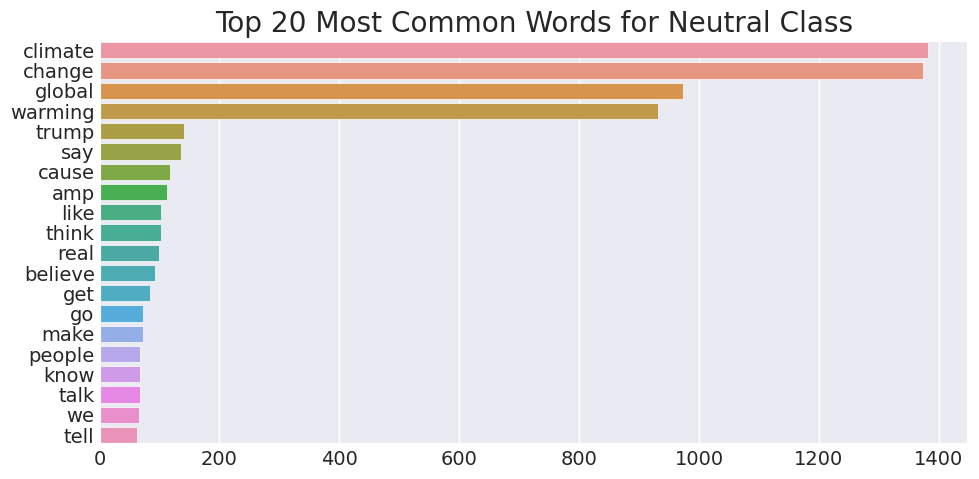

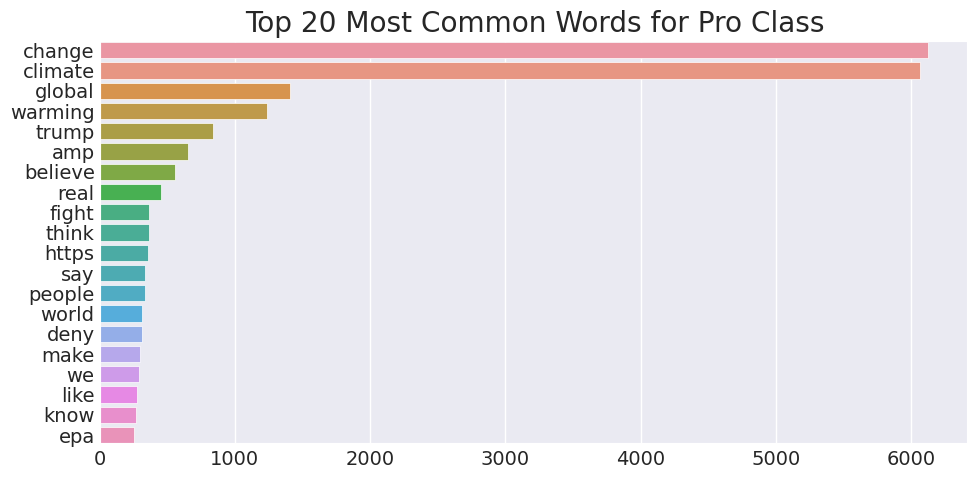

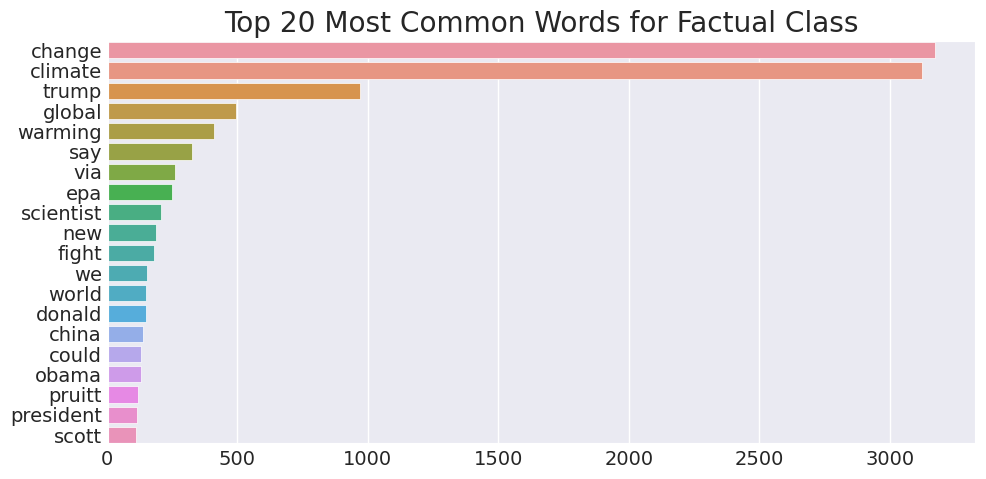

In [50]:
def plot_class_specific_analysis(df, sentiment_class):
    # Filter messages for the given sentiment class
    class_text = ' '.join(df[df['sentiment'] == sentiment_class]['message'])
    plot_frequency_distribution(class_text, sentiment_class)
    
#view word frequency distribution for each class
for sentiment_value, sentiment_class in sentiment_class_dict.items():
    plot_class_specific_analysis(df_train, sentiment_class)
    print('\n')

## 3.4. Vocabulary Distribution

In [51]:
# Function to calculate unique words
def unique_word_count(message):
    return len(set(message.split()))

In [52]:
#extract vocab size
df_train['vocab size'] = df_train['message'].apply(unique_word_count)

In [53]:
df_train.head()

,sentiment,message,tweetid,vocab size
0,Pro,polyscimajor epa chief think carbon dioxide ma...,625221,12
1,Pro,like lack evidence anthropogenic global warming,126103,6
2,Factual,researcher say three year act climate change late,698562,8
3,Pro,wire pivotal year war climate change,573736,6
4,Pro,racist sexist climate change deny bigot lead poll,466954,8


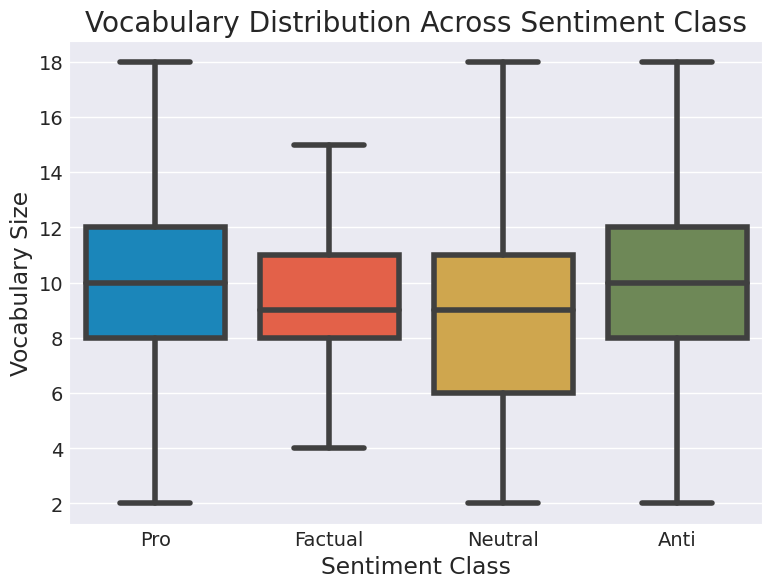

In [54]:
#visusalise vocab distribution
plt.figure(figsize  =(8,6))
sns.boxplot(x = 'sentiment', y = 'vocab size', data = df_train, showfliers = False)
plt.xlabel('Sentiment Class')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Distribution Across Sentiment Class')
plt.show()

In [55]:
#view vocab stats
vocab_stats = df_train.groupby('sentiment')['vocab size'].agg(['mean', 'median', 'std'])
vocab_stats

,mean,median,std
sentiment,,,
Anti,9.696151,10.0,2.986070
Factual,9.227440,9.0,2.300755
Neutral,8.934463,9.0,3.550412
Pro,9.788307,10.0,2.768479


## 3.5. Tweet Length 

In [56]:
#plots the frequency of the most common words 
def word_frequency(df, message):
    return df[message].apply(lambda x: len(x.split()))

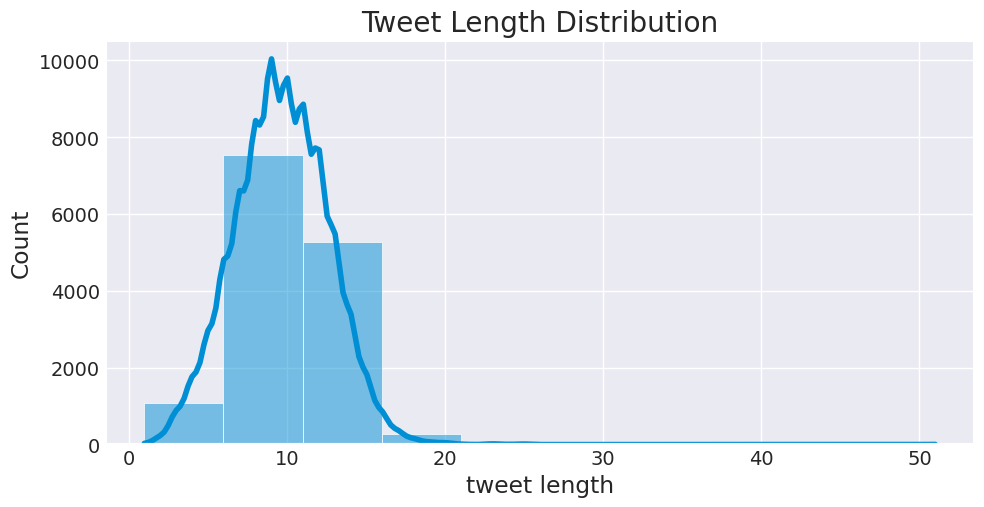

In [57]:
# Calculate tweet lengths
df_train['tweet length'] = word_frequency(df_train, 'message')

# Plot tweet length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_train['tweet length'], bins=10, kde=True)
plt.title('Tweet Length Distribution')
plt.show()

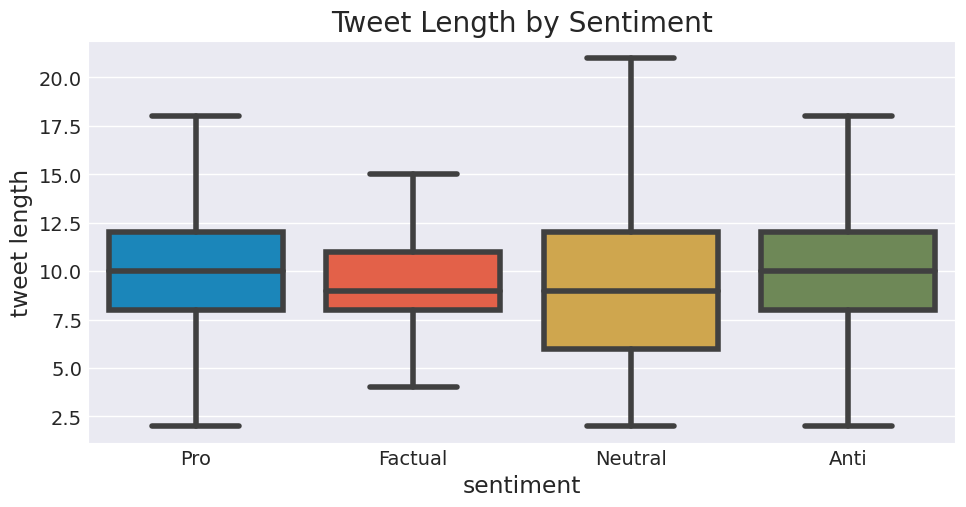

In [58]:
# Compare tweet length by sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment',
            y='tweet length', 
            showfliers = False, 
            palette = sns.color_palette(),
            data=df_train)
plt.title('Tweet Length by Sentiment')
plt.show()

In [59]:
#view vocab stats
vocab_stats = df_train.groupby('sentiment')['tweet length'].agg(['mean', 'median', 'std'])
vocab_stats

,mean,median,std
sentiment,,,
Anti,9.968878,10.0,3.064714
Factual,9.310042,9.0,2.349981
Neutral,9.146233,9.0,3.727327
Pro,9.989886,10.0,2.859275


## 3.6. Vocabulary per Tweet Length

In [60]:
#define vocab per tweet length
df_train['vocab per length'] = df_train['vocab size'].div(df_train['tweet length'])

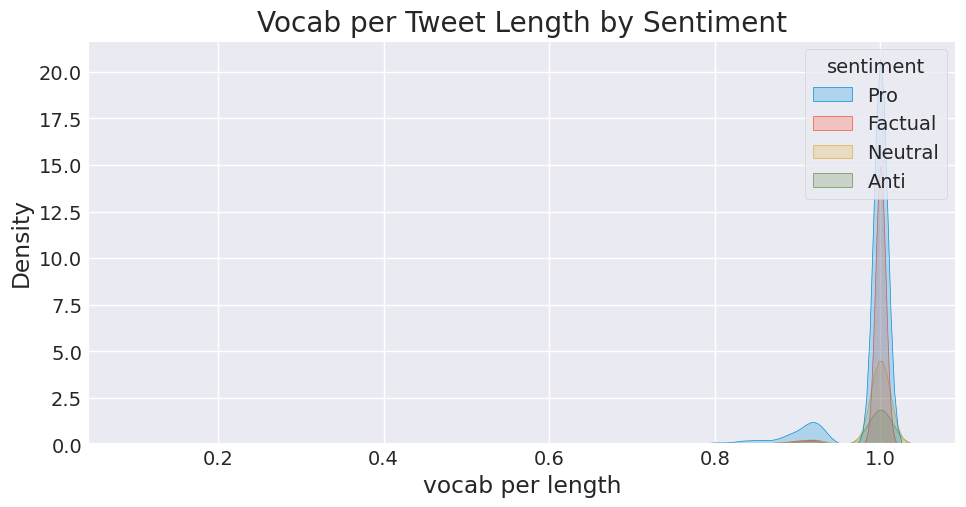

In [61]:
# Compare vocab per tweet length by sentiment
plt.figure(figsize=(10, 5))
sns.kdeplot(x='vocab per length', 
            hue = 'sentiment', 
            fill = True,
            palette = sns.color_palette(),
            data=df_train)
plt.title('Vocab per Tweet Length by Sentiment')
plt.show()

In [62]:
# Perform Kruskal-Wallis H-test
kruskal_result = stats.kruskal(
    df_train[df_train['sentiment'] == 'Pro']['vocab size'],
    df_train[df_train['sentiment'] == 'Anti']['vocab size'],
    df_train[df_train['sentiment'] == 'Factual']['vocab size'],
    df_train[df_train['sentiment'] == 'Neutral']['vocab size']
)

print(f"Kruskal-Wallis H-test resul ----> Statistic Value: {kruskal_result[0]:0.3f} and P-value: {kruskal_result[1]:0.3f}")

Kruskal-Wallis H-test resul ----> Statistic Value: 223.771 and P-value: 0.000


## 3.5. Hashtag Analysis

In [63]:
#view earlier dataset
df_eda.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


In [64]:
#map sentime classes
df_eda['sentiment'] = df_eda['sentiment'].map(sentiment_class_dict)

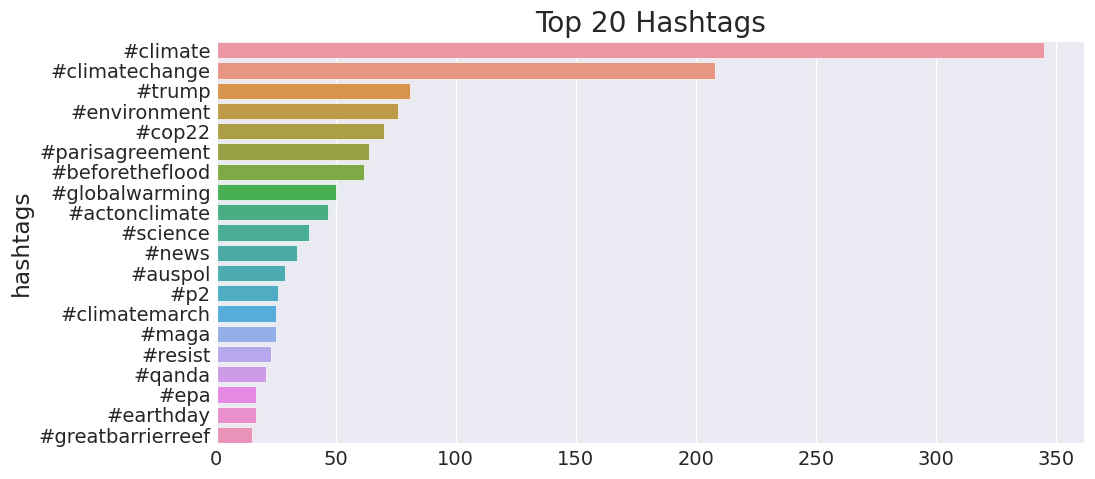

In [65]:
# Function to extract hashtags
def extract_hashtags(message):
    return re.findall(r'#\w+', message)

# Extract hashtags and explode the list to individual rows
df_eda['hashtags'] = df_eda['message'].apply(extract_hashtags)
hashtags = df_eda.explode('hashtags')

# Plot most common hashtags
common_hashtags = hashtags['hashtags'].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=common_hashtags.values, y=common_hashtags.index)
plt.title('Top 20 Hashtags')
plt.show()

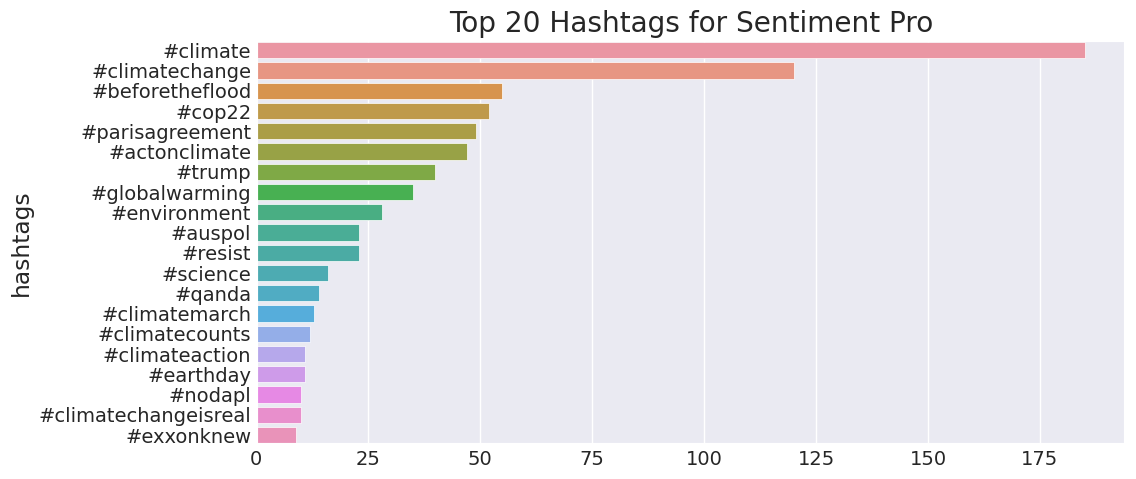

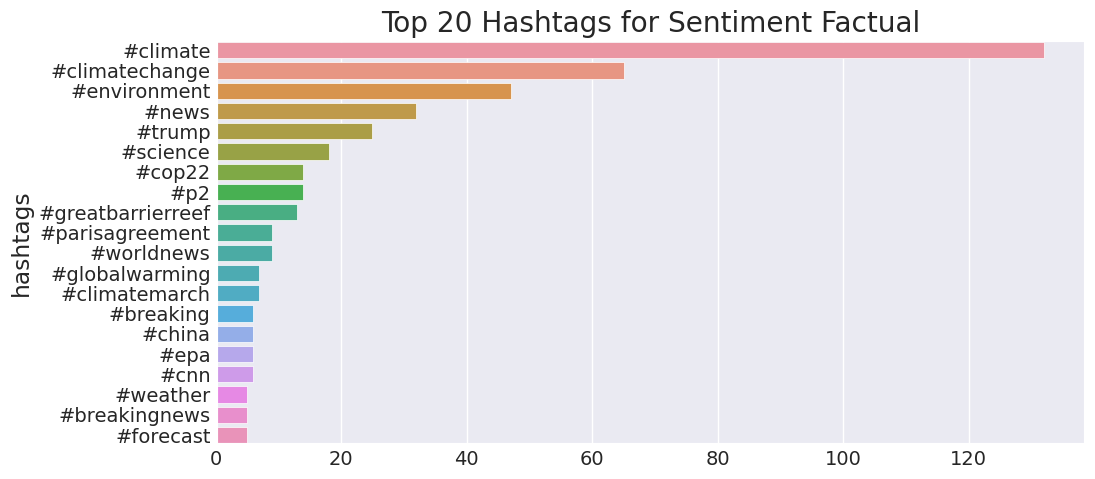

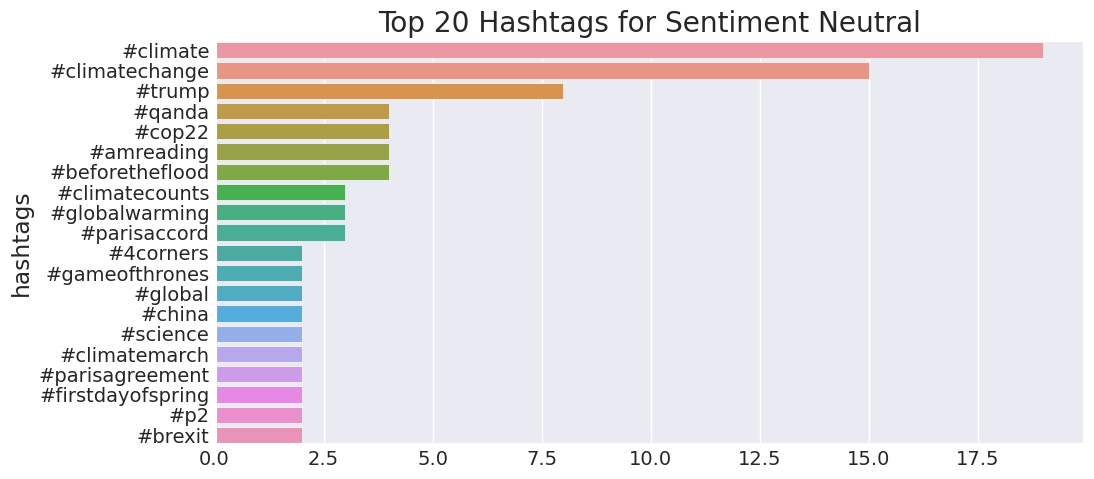

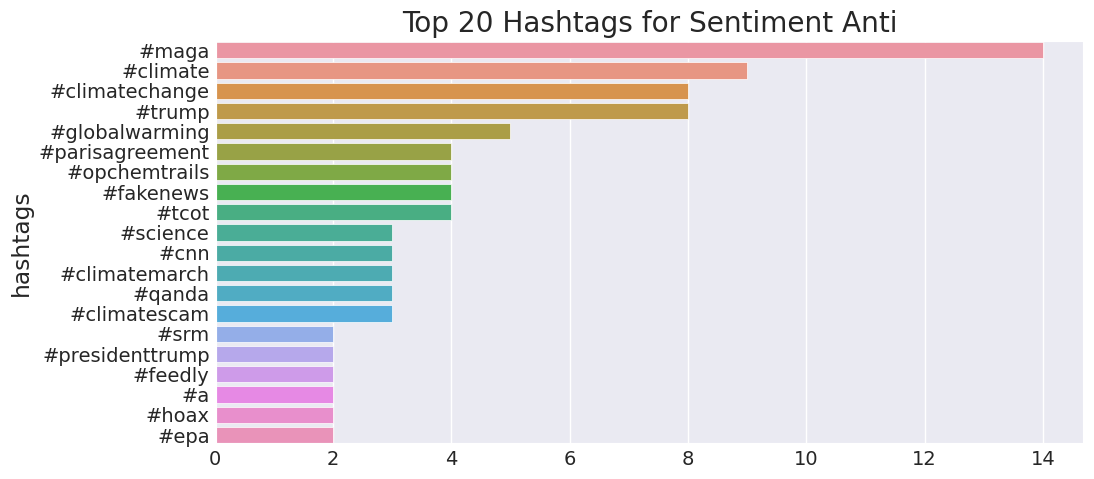

In [66]:
# Plot common hashtags by sentiment
for sentiment in df_eda['sentiment'].unique():
    sentiment_hashtags = hashtags[hashtags['sentiment'] == sentiment]['hashtags'].value_counts().head(20)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=sentiment_hashtags.values, y=sentiment_hashtags.index)
    plt.title(f'Top 20 Hashtags for Sentiment {sentiment}')
    plt.show()
    print('\n')

## 3.6. Mention Analysis

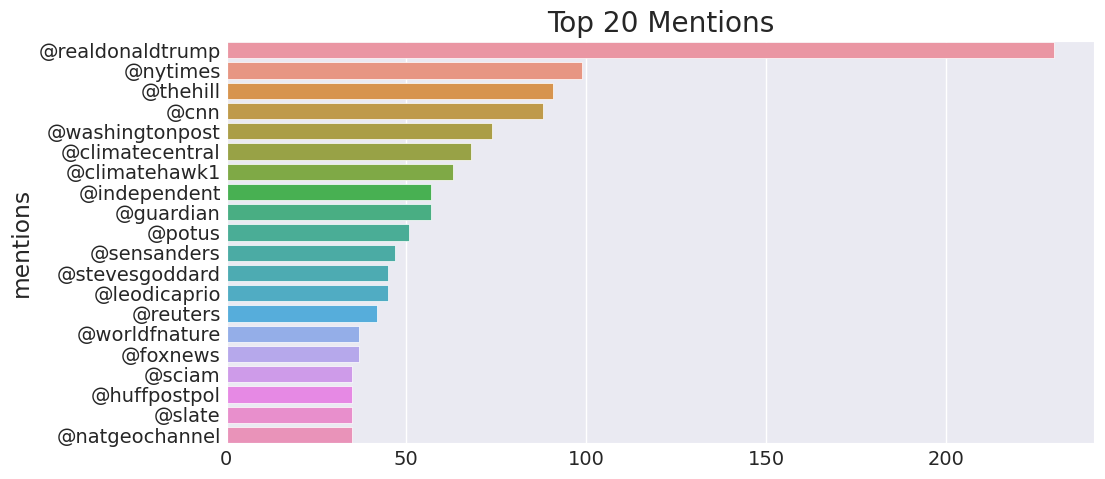

In [67]:
# Function to extract hashtags
def extract_mentions(message):
    return re.findall(r"@[\w]*", message)

# Extract mentions and explode the list to individual rows
df_eda['mentions'] = df_eda['message'].apply(extract_mentions)
mentions = df_eda.explode('mentions')

# Plot most common mentions
common_mentions = mentions['mentions'].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=common_mentions.values, y=common_mentions.index)
plt.title('Top 20 Mentions')
plt.show()

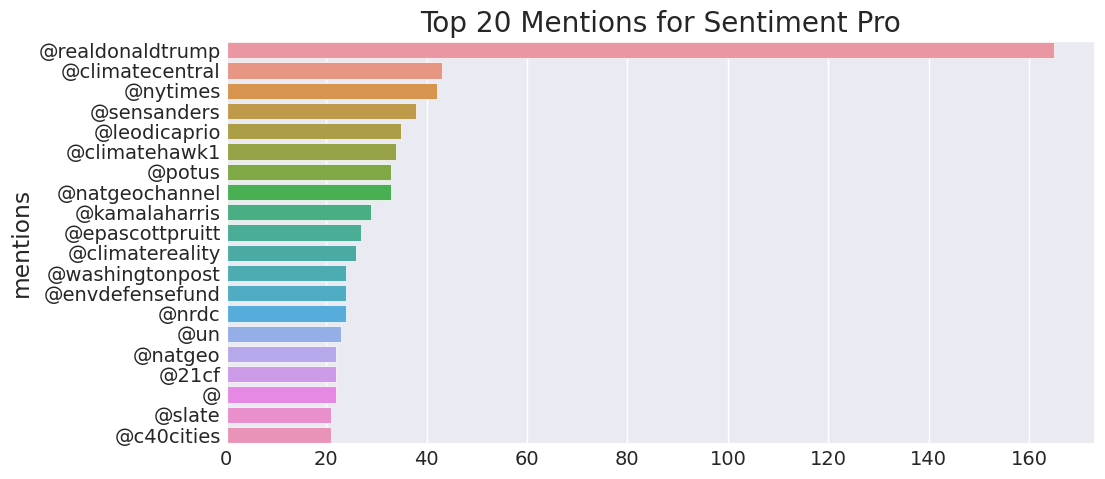

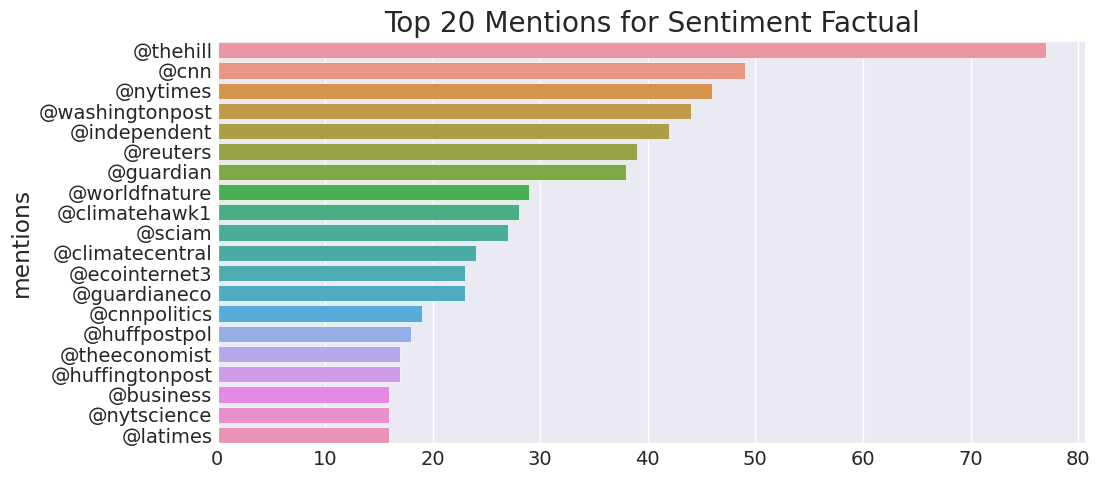

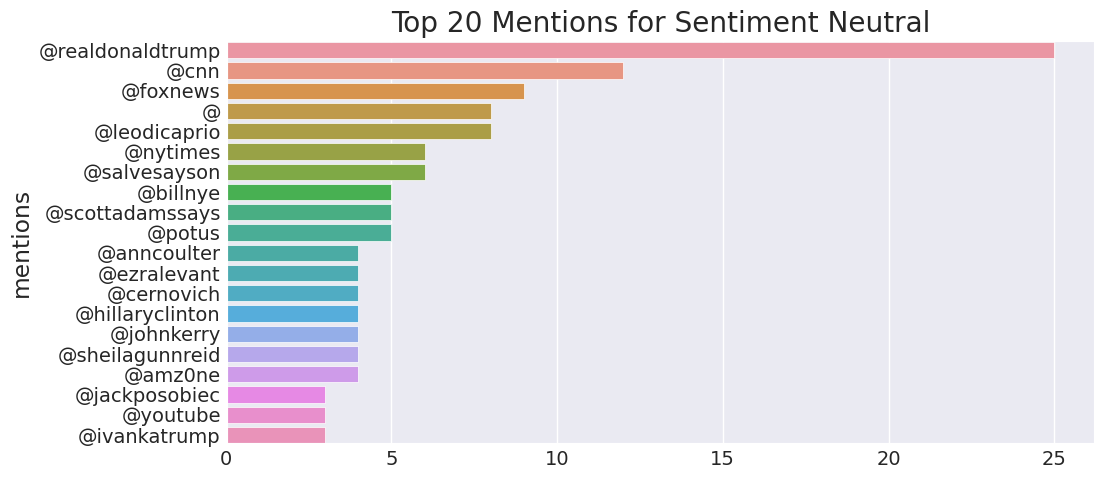

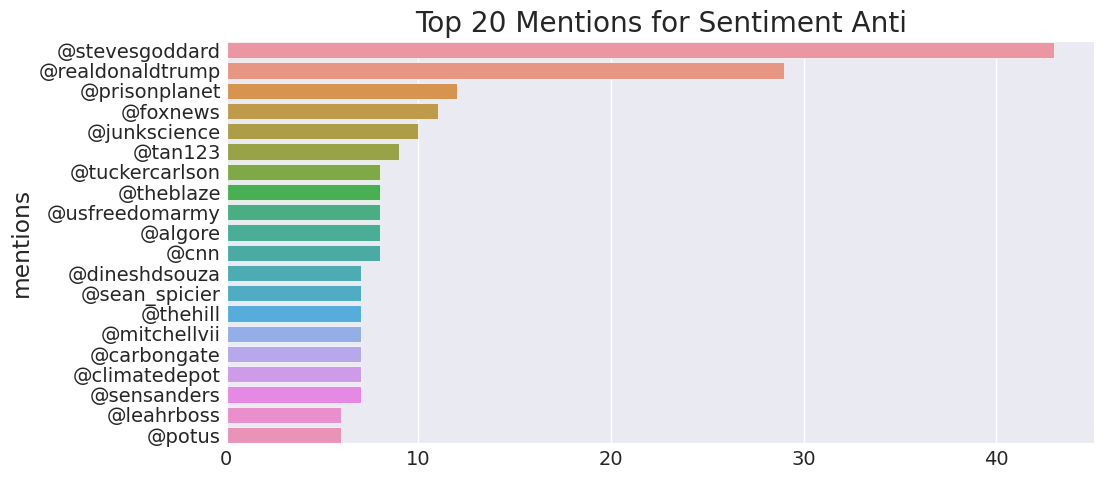

In [68]:
# Plot common hashtags by sentiment
for sentiment in df_eda['sentiment'].unique():
    sentiment_mentions = mentions[mentions['sentiment'] == sentiment]['mentions'].value_counts().head(20)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=sentiment_mentions.values, y=sentiment_mentions.index)
    plt.title(f'Top 20 Mentions for Sentiment {sentiment}')
    plt.show()
    print('\n')

# 4. Feature Extraction

Converts text data into numerical features suitable for machine learning models. This includes:

- **Tokenization and Document-Term Matrix**: `CountVectorizer` from `sklearn` tokenizes the text and creates a sparse matrix of token counts.
- **TF-Idf**: `Tfidf_trainVectorizer` transforms text into term frequency-inverse document frequency features, capturing the importance of words in the context of the entire dataset.

## 4.1. Count Vectorizer 

In [69]:
# Tokenization | document-term matrix
vectorizer = CountVectorizer(analyzer = 'word', dtype = np.int64, stop_words = 'english')

#vectorize training dataset
X_train_cv = vectorizer.fit_transform(df_train['message']).toarray()
X_test_cv = vectorizer.transform(df_test['message']).toarray()

## 4.2. TF-IDF Vectorizer

In [70]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', dtype = np.float64, ngram_range = (1,1), norm = 'l2', stop_words = 'english',  smooth_idf = True)

#vectorize training dataset
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['message']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_test['message']).toarray()

In [71]:
#save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# 5. Modelling

Involves training machine learning models on the extracted features to predict sentiment. This step includes:

  - **Traditional Machine Learning**: Models like logistic regression (`LogisticRegression` from `sklearn`) are trained on TF-Idf_train features.
  - **Deep Neural Network**: Build a basic feedforward neural network using Tensorflow

In [72]:
#define comet ai object
experiment = Experiment(
    api_key = os.environ.get('API_KEY'),
    project_name = 'climate-change-sentiment-analysis',
    workspace = 'nomaguguk'
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failing to collect the installed pip packages
COMET INFO: Experiment is live on comet.com https://www.comet.com/nomaguguk/climate-change-sentiment-analysis/349ba738cc9f44d7963889f40af9a486



In [73]:
sentiment_class_dict_inv = {'Anti': -1, 'Neutral': 0, 'Pro': 1, 'Factual': 2}

In [74]:
#define dataset for modelling 
#mapping
df_train['sentiment'] = df_train['sentiment'].map(sentiment_class_dict_inv) 

##split into training abd validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_tfidf, df_train['sentiment'], 
                                    test_size = 0.2, stratify = df_train['sentiment'],
                                    shuffle = True, random_state = 42)
#define test dataset
X_test = X_test_tfidf

## 5.1. Baseline Modelling

In [75]:
#random forest
rf_params = {'class_weight': 'balanced', 
            'criterion': 'gini', 
            'max_features': 'sqrt', 
            'n_estimators': 150,
            'n_jobs': -1,
            'random_state' : 42}

rf = RandomForestClassifier(**rf_params)

#----------------------------------------------
#gaussian naive bayes
gnb_params = {'priors': None, 
              'var_smoothing': 1e-09}

gnb = GaussianNB(**gnb_params)

#---------------------------------------------
knn_params = {'algorithm': 'auto',
             'leaf_size': 30,
             'metric': 'minkowski',
             'n_jobs': -1,
             'n_neighbors': 30,
             'p': 2,
             'weights': 'uniform'}

knn = KNeighborsClassifier(**knn_params)

#---------------------------------------------
#lightgbm 
lgbm_params = {'boosting_type': 'gbdt',
             'class_weight': 'balanced',
             'importance_type': 'gain',
             'learning_rate': 0.5,
             'max_depth': 5,
             'n_estimators': 350,
             'n_jobs': -1,
             'num_leaves': 32,
             'random_state': 42,
             'reg_alpha': 2.0,
             'reg_lambda': 2.0}

lgbm = LGBMClassifier(**lgbm_params)

#----------------------------------------------
#collect models
models = {'Random Forest': rf,
          'LightGBM': lgbm,
          'Gaussian Naive Bayes': gnb,
          'KNearest Neighbour': knn
         }

In [76]:
#define function for logging parameters and metrics
def experimental_logging(model_name, params, cm, metrics):

    #log parameters
    experiment.log_parameters(params)

    #log metrics 
    experiment.log_metrics(metrics)

    #log confusion matrix
    experiment.log_confusion_matrix(matrix=cm, 
                                    labels=[-1, 0, 1,2],
                                    title = f"Confusion Matrix for {model_name}",
                                    filename = f"{model_name}-confusion-matrix.json")

--------------------Training for Random Forest---------------------------
Balanced accuracy for Random Forest: 51.67%
F1 score for Random Forest: 55.52%
Precision score for Random Forest: 68.59%
Recall score for Random Forest: 51.67%


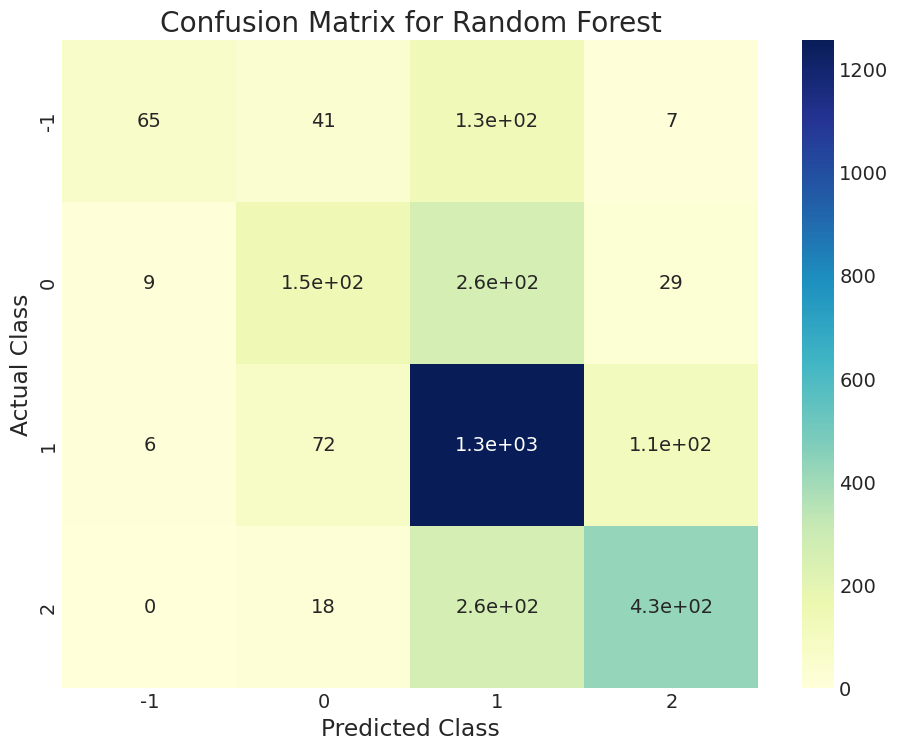

              precision    recall  f1-score   support

          -1       0.81      0.27      0.40       244
           0       0.53      0.33      0.40       449
           1       0.66      0.87      0.75      1444
           2       0.75      0.60      0.67       707

    accuracy                           0.67      2844
   macro avg       0.69      0.52      0.56      2844
weighted avg       0.67      0.67      0.64      2844

--------------------------------------------------------------------------------------------------------------------------

--------------------Training for LightGBM---------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17408
[LightGBM] [Info] Number of data points in the train set: 11373, number of used features: 731
[LightGBM] [Info]

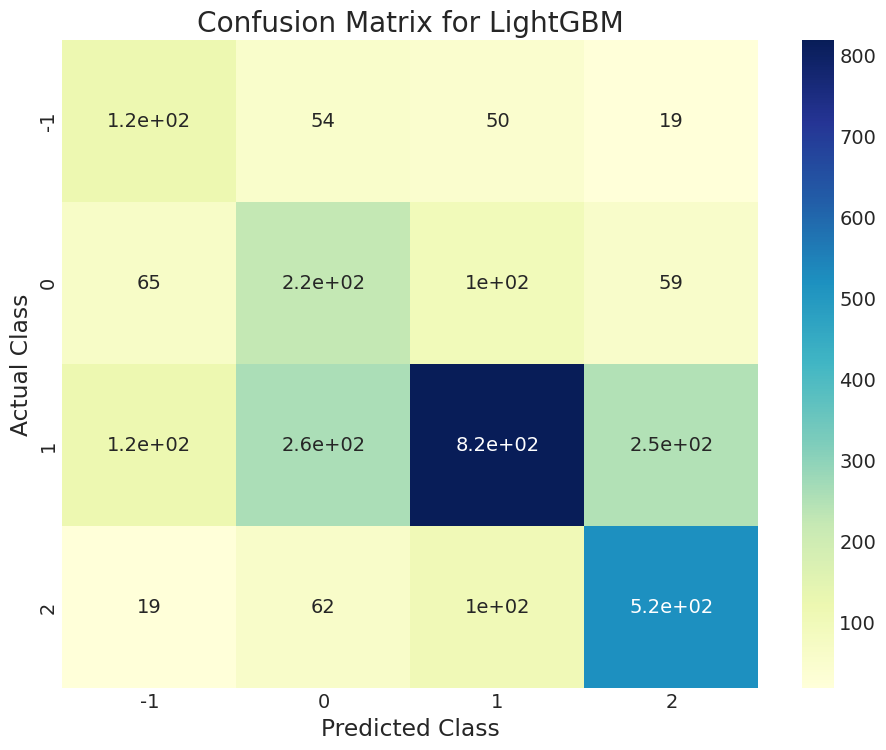

              precision    recall  f1-score   support

          -1       0.37      0.50      0.43       244
           0       0.38      0.50      0.43       449
           1       0.76      0.57      0.65      1444
           2       0.61      0.74      0.67       707

    accuracy                           0.59      2844
   macro avg       0.53      0.58      0.54      2844
weighted avg       0.63      0.59      0.60      2844

--------------------------------------------------------------------------------------------------------------------------

--------------------Training for Gaussian Naive Bayes---------------------------
Balanced accuracy for Gaussian Naive Bayes: 42.69%
F1 score for Gaussian Naive Bayes: 37.44%
Precision score for Gaussian Naive Bayes: 39.44%
Recall score for Gaussian Naive Bayes: 42.69%


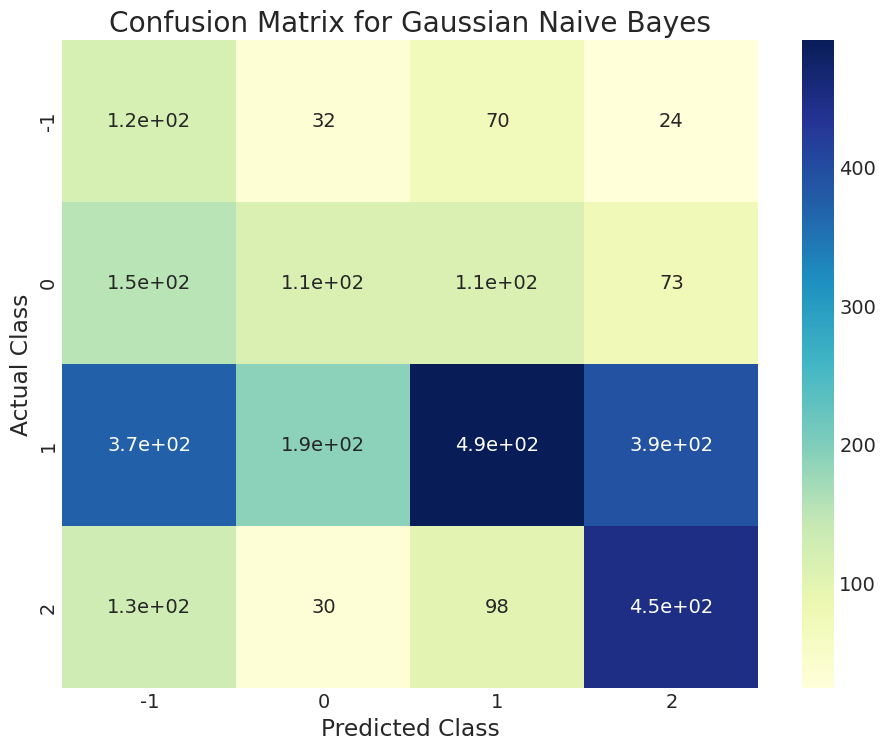

              precision    recall  f1-score   support

          -1       0.15      0.48      0.23       244
           0       0.31      0.25      0.28       449
           1       0.64      0.34      0.44      1444
           2       0.48      0.63      0.55       707

    accuracy                           0.41      2844
   macro avg       0.39      0.43      0.37      2844
weighted avg       0.50      0.41      0.42      2844

--------------------------------------------------------------------------------------------------------------------------

--------------------Training for KNearest Neighbour---------------------------
Balanced accuracy for KNearest Neighbour: 44.95%
F1 score for KNearest Neighbour: 47.19%
Precision score for KNearest Neighbour: 63.35%
Recall score for KNearest Neighbour: 44.95%


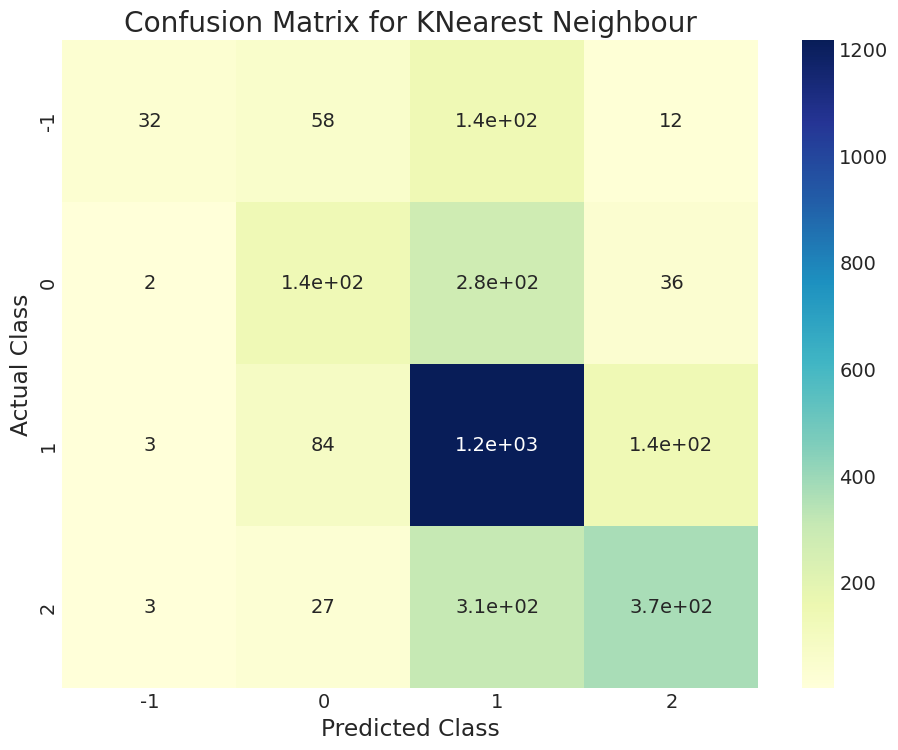

              precision    recall  f1-score   support

          -1       0.80      0.13      0.23       244
           0       0.44      0.30      0.36       449
           1       0.63      0.84      0.72      1444
           2       0.66      0.52      0.58       707

    accuracy                           0.62      2844
   macro avg       0.63      0.45      0.47      2844
weighted avg       0.62      0.62      0.59      2844

--------------------------------------------------------------------------------------------------------------------------



In [77]:
#baseline training for model selection
for model_name, clf in models.items():
    
    print(f"--------------------Training for {model_name}---------------------------")

    #fit dataset
    clf.fit(X_train, y_train)

    #predict 
    y_pred = clf.predict(X_valid)

    #evaluate
    ##balanced accuracy
    bal_acc = balanced_accuracy_score(y_valid, y_pred)
    print(f'Balanced accuracy for {model_name}: {100*bal_acc:.2f}%')

    ##f1 score
    f1 = f1_score(y_valid, y_pred, average = 'macro')
    print(f'F1 score for {model_name}: {100*f1:.2f}%')

    ##precision
    precision = precision_score(y_valid, y_pred, average = 'macro')
    print(f'Precision score for {model_name}: {100*precision:.2f}%')

    ##recall
    recall = recall_score(y_valid, y_pred, average = 'macro')
    print(f'Recall score for {model_name}: {100*recall:.2f}%')

    metrics = {'balanced accuracy': bal_acc,
              'f1 score': f1,
              'precision score': precision,
              'recall score': recall}
    
    
    #confusion matrix 
    plt.figure(figsize = (10,8))
    cm = confusion_matrix(y_valid, y_pred) 
    sns.heatmap(cm, 
                cmap = "YlGnBu",
                xticklabels=clf.classes_, 
                yticklabels=clf.classes_, 
                annot=True)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    #classification report
    print(classification_report(y_valid, y_pred))
    
    #define parameters
    params = clf.get_params()
    
    #log parameters and metrics
    experimental_logging(model_name, params, cm, metrics)
    
    print('--------------------------------------------------------------------------------------------------------------------------\n')

## 5.2. Final Model Selection

In [78]:
#final model | random forest
params = {'class_weight': 'balanced', 
            'criterion': 'gini', 
            'max_features': 'sqrt', 
            'n_estimators': 150,
            'n_jobs': -1,
            'random_state' : 42}

model = RandomForestClassifier(**params)

Balanced accuracy for Random Forest | Final Model: 51.67%
F1 score for Random Forest | Final Model: 64.40%
Precision score for Random Forest | Final Model: 67.19%
Recall score for Random Forest | Final Model: 66.63%


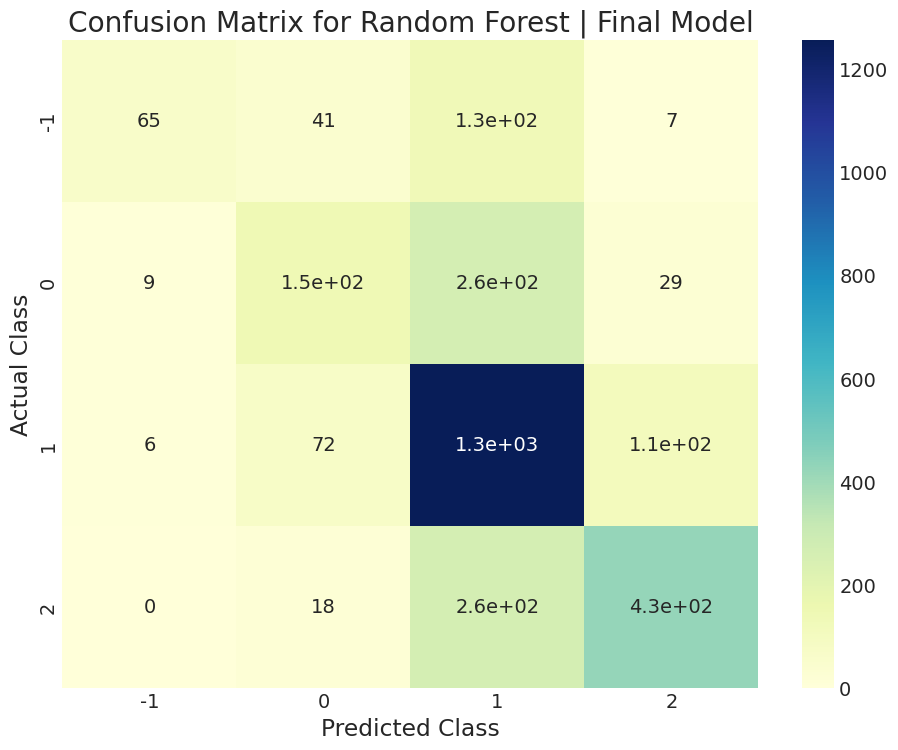

              precision    recall  f1-score   support

          -1       0.81      0.27      0.40       244
           0       0.53      0.33      0.40       449
           1       0.66      0.87      0.75      1444
           2       0.75      0.60      0.67       707

    accuracy                           0.67      2844
   macro avg       0.69      0.52      0.56      2844
weighted avg       0.67      0.67      0.64      2844



In [79]:
#define model
model_name = "Random Forest | Final Model"

#fit and evaluate
model.fit(X_train, y_train)

#evaluate
y_pred = model.predict(X_valid)

#evaluate
##balanced accuracy
bal_acc = balanced_accuracy_score(y_valid, y_pred)
print(f'Balanced accuracy for {model_name}: {100*bal_acc:.2f}%')

##f1 score
f1 = f1_score(y_valid, y_pred, average = 'weighted')
print(f'F1 score for {model_name}: {100*f1:.2f}%')

##precision
precision = precision_score(y_valid, y_pred, average = 'weighted')
print(f'Precision score for {model_name}: {100*precision:.2f}%')

##recall
recall = recall_score(y_valid, y_pred, average = 'weighted')
print(f'Recall score for {model_name}: {100*recall:.2f}%')

metrics = {'balanced accuracy': bal_acc,
          'f1 score': f1,
          'precision score': precision,
          'recall score': recall}


#confusion matrix 
plt.figure(figsize = (10,8))
cm = confusion_matrix(y_valid, y_pred) 
sns.heatmap(cm, 
            cmap = "YlGnBu",
            xticklabels=model.classes_, 
            yticklabels=model.classes_, 
            annot=True)
plt.title(f"Confusion Matrix for {model_name}")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

#classification report
print(classification_report(y_valid, y_pred))

In [80]:
#log best hyperameters
experiment.log_parameters(model.get_params())

metrics = {'balanced accuracy': bal_acc,
          'f1 score': f1,
          'precision score': precision,
          'recall score': recall}

#log final metrics 
experiment.log_metrics(metrics)

#save model
with open("rf_best_model.pkl", "wb") as f:
    pickle.dump(model, f)

#log model 
experiment.log_model("Random Classifier", "rf_best_model.pkl")

#end experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : internal_sparrow_3121
COMET INFO:     url                   : https://www.comet.com/nomaguguk/climate-change-sentiment-analysis/349ba738cc9f44d7963889f40af9a486
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     balanced accuracy [5] : (0.42685833811181995, 0.57563017907014)
COMET INFO:     f1 score [5]          : (0.37435212678038654, 0.6440063246576194)
COMET INFO:     precision score [5]   : (0.3943612024434854, 0.6859333474791227)
COMET INFO:     recall score [5]      : (0.42685833811181995, 0.6663150492264416)
COMET INFO:   Parameters:
COMET INFO:     algorithm                : auto
COMET INFO:     boosting_type            : gbdt
COMET IN

# 6. Inference | Test Data Scoring

In [81]:
#aply model on test data 
y_test_class = model.predict(X_test)

#set sentiment class
df_test['sentiment'] = y_test_class

In [82]:
#view
df_test.head()

,message,tweetid,sentiment
0,europe look china make sure alone fight climat...,169760,1
1,combine polling staffer climate change women r...,35326,1
2,scary unimpeachable evidence climate change al...,224985,1
3,putin get jill trump believe climate change th...,476263,1
4,female orgasm cause global warming sarcastic r...,872928,0


In [85]:
#save test predictions 
df_test[['tweetid', 'sentiment']].to_csv('climate_change_sentiment_analysis_test.csv', index = False)

# 7. Deployment via Streamlit

Streamlit is a powerful tool for building interactive web applications with minimal code. This step involves creating a simple web app where users can input a tweet, and the model will predict its sentiment. The app provides an intuitive interface for users to interact with the sentiment analysis model.

In [86]:
st.title('Climate Change Sentiment Analysis')
tweet = st.text_input('Enter a tweet:')

#sentiment dictionary
sentiment_class_dict = {-1: 'Anti', 0: 'Neutral', 1: 'Pro', 2: 'Factual'}

#define nlp object for stopwords
nlp = spacy.load("en_core_web_sm")

if st.button('Analyze Sentiment'):
    if tweet:
        #normalize tweet
        tweet = tweet.str.lower()
        #filter noise
        filtered_tweer = tweet_filtering(tweet)
        #remove stopwords
        tweet = remove_stopwords(tweet)
        #lemmatize
        tweet = lemmatize_text(tweet)
        #vectorize
        tweet_tfidf = tfidf_vectorizer.transform([tweet]).toarray()
        #prediction
        prediction = model.predict(tweet_tfidf)
        #define sentiment
        sentiment = sentiment_class_dict[prediction]
        #display output
        st.write('Sentiment:', sentiment)
        
        # Log the prediction to Comet.ml
        experiment.log_text("input_tweet", tweet)
        experiment.log_metric("predicted_sentiment", sentiment)
    else:
        st.write('Please enter a tweet text')

2024-06-17 14:46:19.522 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-06-17 14:46:19.524 Session state does not function when running a script without `streamlit run`
